### Import the importance libraries

In [1]:
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
from sklearn.model_selection import train_test_split


In [2]:
from tensorflow import keras
(x_train_full, y_train_full), (x_test_orig, y_test_orig) = tf.keras.datasets.mnist.load_data()

# Combine original train and test sets
x_all = np.concatenate((x_train_full, x_test_orig), axis=0)
y_all = np.concatenate((y_train_full, y_test_orig), axis=0)

# Normalize
x_all = x_all / 255.0

# Shuffle before splitting
np.random.seed(42)  # for reproducibility
indices = np.random.permutation(len(x_all))

# 80/20 split
split_index = int(0.8 * len(x_all))
train_idx, test_idx = indices[:split_index], indices[split_index:]

x_train, y_train = x_all[train_idx], y_all[train_idx]
x_test, y_test = x_all[test_idx], y_all[test_idx]

print(f"Train set: {x_train.shape}, Test set: {x_test.shape}")

Train set: (56000, 28, 28), Test set: (14000, 28, 28)


In [3]:
x_train.shape

(56000, 28, 28)

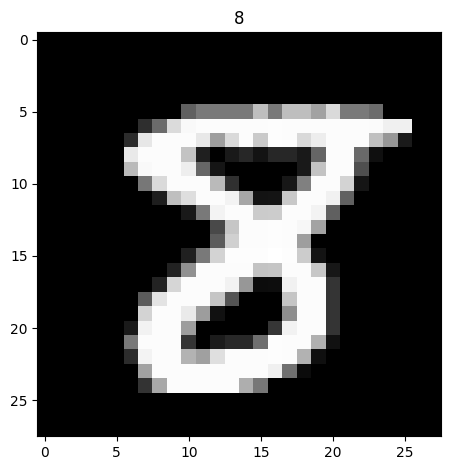

In [4]:
plt.imshow(x_train[0],cmap = 'gray')
plt.title(y_train[0])
plt.tight_layout()
plt.show()

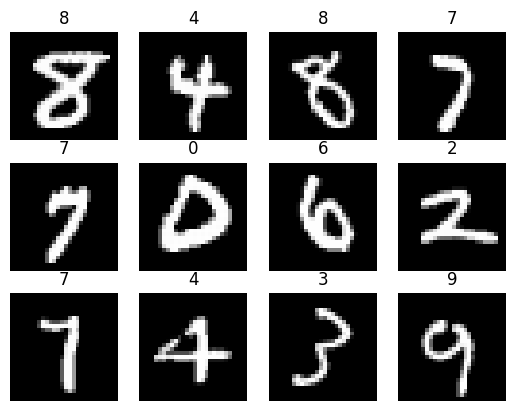

In [5]:

for i in range(12):
    plt.subplot(3,4, i+ 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
    
plt.show()

### Build the model 
In this step I want to use sigmoid for the activate function and there are 128 neurons for hidden 1 and 64 layers for hidden 2

In [6]:
input_size = 28*28
hidden1 = 128
hidden2 = 64
output = 10

In [7]:
initializer = tf.keras.initializers.GlorotUniform()

w1 = tf.Variable(initializer([input_size, hidden1]))
b1 = tf.Variable(tf.zeros([hidden1]))

w2 = tf.Variable(initializer([hidden1, hidden2]))
b2 = tf.Variable(tf.zeros([hidden2]))

w3 = tf.Variable(initializer([hidden2, output]))
b3 = tf.Variable(tf.zeros([output]))

In [8]:
def model(x):
    
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, [x.shape[0], -1])
    
    z1 = tf.matmul(x,w1) + b1
    a1 = tf.sigmoid(z1)
    
    z2 = tf.matmul(a1,w2) + b2
    a2 = tf.sigmoid(z2)
    
    z3 = tf.matmul(a2, w3) + b3
    output = tf.nn.softmax(z3)
    return output

In [9]:

def cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))


In [10]:
epochs = 10
lr = 0.01
batch_size = 64
optimizer = tf.optimizers.SGD(learning_rate=lr)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)

# Training loop with loss display
for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0

    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            preds = model(x_batch)
            loss = loss_fn(y_batch, preds)

        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        optimizer.apply_gradients(zip(grads, [w1, b1, w2, b2, w3, b3]))

        epoch_loss += loss.numpy()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 2.2595
Epoch 2, Loss: 2.1334
Epoch 3, Loss: 1.8997
Epoch 4, Loss: 1.5513
Epoch 5, Loss: 1.2394
Epoch 6, Loss: 1.0232
Epoch 7, Loss: 0.8742
Epoch 8, Loss: 0.7660
Epoch 9, Loss: 0.6838
Epoch 10, Loss: 0.6202


In [11]:
y_pred = model(x_test)


In [31]:
y_pred = tf.argmax(y_pred, 1)

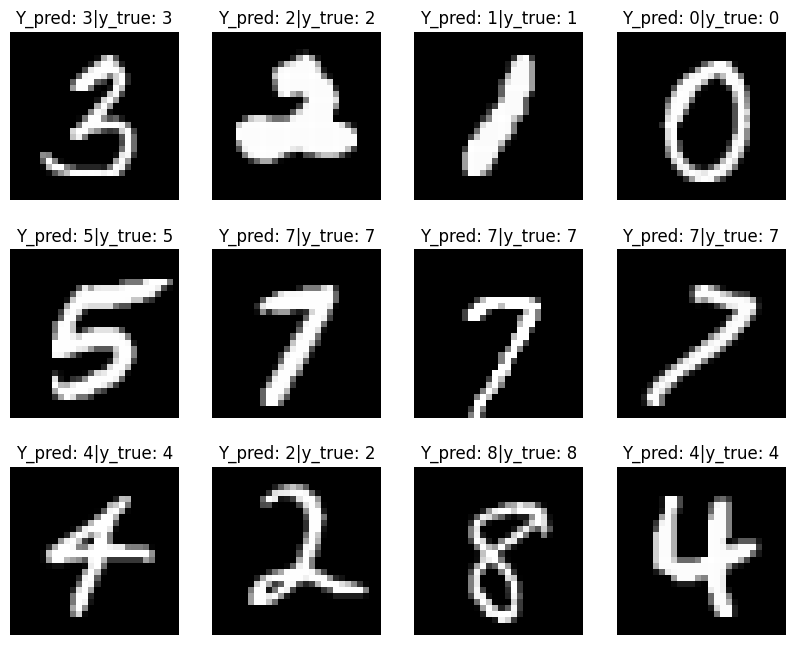

In [32]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(x_test[i], cmap = 'gray')
    plt.title(f"Y_pred: {y_pred[i]}|y_true: {y_test[i]}")
    plt.axis('off')
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

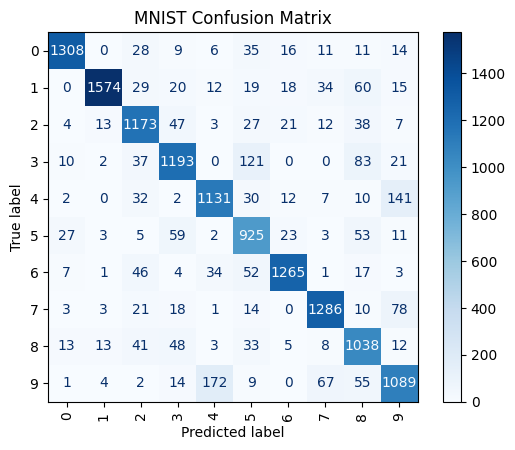

In [15]:
cm = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("MNIST Confusion Matrix")
plt.show()


In [16]:
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1375
           1       0.88      0.98      0.93      1613
           2       0.87      0.83      0.85      1414
           3       0.81      0.84      0.83      1414
           4       0.83      0.83      0.83      1364
           5       0.83      0.73      0.78      1265
           6       0.88      0.93      0.91      1360
           7       0.90      0.90      0.90      1429
           8       0.86      0.75      0.80      1375
           9       0.77      0.78      0.78      1391

    accuracy                           0.86     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.86      0.86      0.85     14000



### Use package for sigmoid is the activate function and the layer still the same

In [17]:
from tensorflow.keras import layers, Model
import tensorflow as tf

def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)  # Input layer

    x = layers.Flatten()(inputs) 
    x = layers.Dense(128, activation='sigmoid')(x)

    x = layers.Dense(64, activation='sigmoid')(x)

    outputs = layers.Dense(10, activation='softmax')(x)  # 10 classes for classification
   
    model = Model(inputs=inputs, outputs=outputs)
    
    return model
input_shape = x_train.shape[1:] 
model = build_model(input_shape)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7129 - loss: 1.1491 - val_accuracy: 0.9108 - val_loss: 0.3094
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9266 - loss: 0.2632 - val_accuracy: 0.9346 - val_loss: 0.2228
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9448 - loss: 0.1921 - val_accuracy: 0.9452 - val_loss: 0.1796
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9583 - loss: 0.1464 - val_accuracy: 0.9555 - val_loss: 0.1577
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9655 - loss: 0.1196 - val_accuracy: 0.9596 - val_loss: 0.1341
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9711 - loss: 0.0996 - val_accuracy: 0.9627 - val_loss: 0.1256
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9770 - loss: 0.0833 - val_accuracy: 0.9643 - val_loss: 0.1182
Epoch 8/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9808 - loss: 0.0706 - val_accuracy: 0.

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

438/438 - 1s - 3ms/step - accuracy: 0.9717 - loss: 0.0920
Test Loss: 0.0920
Test Accuracy: 0.9717


In [20]:
y_pred = model.predict(x_test)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


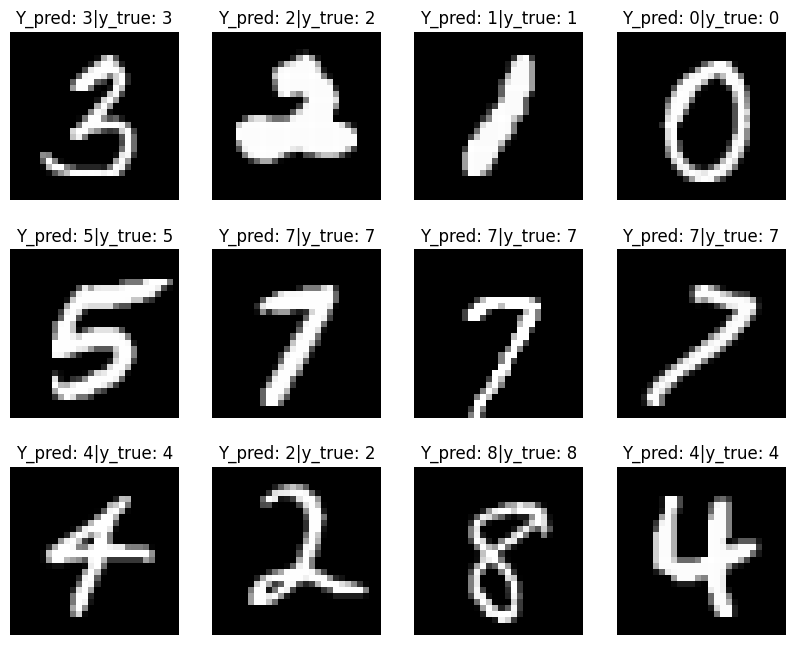

In [29]:
y_pred = model.predict(x_test)
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3,4, i+ 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Y_pred: {np.argmax(y_pred[i])}|y_true: {y_test[i]}")
    plt.axis('off')
plt.show()

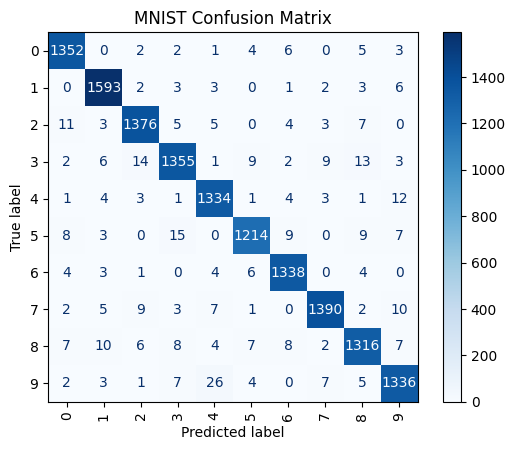

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1375
           1       0.98      0.99      0.98      1613
           2       0.97      0.97      0.97      1414
           3       0.97      0.96      0.96      1414
           4       0.96      0.98      0.97      1364
           5       0.97      0.96      0.97      1265
           6       0.98      0.98      0.98      1360
           7       0.98      0.97      0.98      1429
           8       0.96      0.96      0.96      1375
           9       0.97      0.96      0.96      1391

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



In [22]:
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("MNIST Confusion Matrix")
plt.show()
report = classification_report(y_test, np.argmax(y_pred, axis=1))
print("Classification Report:\n")
print(report)

### Use relu for the activate function

In [23]:
import tensorflow as tf
from tensorflow.keras import layers

# Build the CNN model using Sequential
model = tf.keras.Sequential([
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten layer to connect to Dense layers
    layers.Flatten(),
    
    # Fully connected layer
    layers.Dense(128, activation='relu'),
    
    # Output layer for classification (10 classes)
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.8388 - loss: 0.5116 - val_accuracy: 0.9699 - val_loss: 0.0980
Epoch 2/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9760 - loss: 0.0788 - val_accuracy: 0.9728 - val_loss: 0.0868
Epoch 3/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9844 - loss: 0.0520 - val_accuracy: 0.9779 - val_loss: 0.0710
Epoch 4/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9868 - loss: 0.0421 - val_accuracy: 0.9826 - val_loss: 0.0608
Epoch 5/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9905 - loss: 0.0299 - val_accuracy: 0.9839 - val_loss: 0.0604
Epoch 6/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9914 - loss: 0.0250 - val_accuracy: 0.9822 - val_loss: 0.0612
Epoch 7/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9932 - loss: 0.0191 - val_accuracy: 0.9846 - val_loss: 0.0582
Epoch 8/10
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9945 -

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,424 (1.26 MB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 220,950 (863.09 KB)

In [25]:
model.evaluate(x_test, y_test, verbose=2)


438/438 - 2s - 4ms/step - accuracy: 0.9880 - loss: 0.0499


[0.049894317984580994, 0.9879999756813049]

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


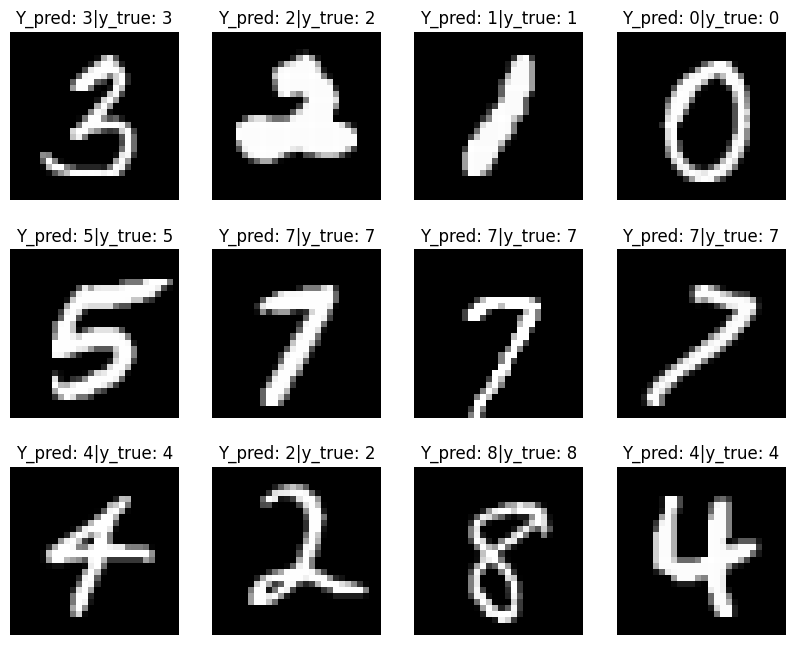

In [28]:
y_pred =model.predict(x_test)
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3,4, i+ 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Y_pred: {np.argmax(y_pred[i])}|y_true: {y_test[i]}")
    plt.axis('off')
plt.show()

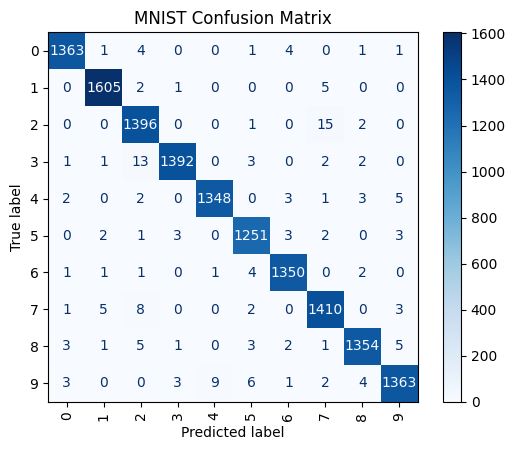

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1375
           1       0.99      1.00      0.99      1613
           2       0.97      0.99      0.98      1414
           3       0.99      0.98      0.99      1414
           4       0.99      0.99      0.99      1364
           5       0.98      0.99      0.99      1265
           6       0.99      0.99      0.99      1360
           7       0.98      0.99      0.98      1429
           8       0.99      0.98      0.99      1375
           9       0.99      0.98      0.98      1391

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



In [27]:
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("MNIST Confusion Matrix")
plt.show()
report = classification_report(y_test, np.argmax(y_pred, axis=1))
print("Classification Report:\n")
print(report)